# Conversion Rate Project



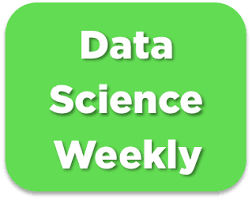

### Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score !

In [3]:
# import
import os
import json
import joblib
import joblib
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)





## Load data

In [5]:
# load dataset
df = pd.read_csv("/content/conversion_data_train.csv")

df.shape

(284580, 6)

## EDA

#### General statistics

In [6]:
    # Basic stats
    print("Number of rows : {}".format(df.shape[0]))
    print()

    print("Display of dataset: ")
    display(df.head())
    print()

    print("Basics statistics: ")
    data_desc = df.describe(include='all')
    display(data_desc)
    print()

    print("General information: ")
    display(df.info())
    print()

    print("Percentage of missing values: ")
    display(100*df.isnull().sum()/df.shape[0])



Number of rows : 284580

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



General information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


None


Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

#### Visualizations

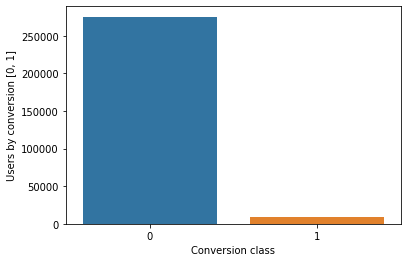

In [7]:
converted_df = pd.DataFrame(df.groupby(["converted"]).size()).reset_index()
converted_df = converted_df.rename(columns={0: "Users by conversion [0, 1]", 
                                            "converted" : "Conversion class"})     

# bar plot by conversion class
ax = sns.barplot(x="Conversion class", y="Users by conversion [0, 1]", data=converted_df)

In [8]:
# converted by country
converted_country_df = df.groupby(["country", "converted"]) \
                                    .size()

display(converted_country_df)


country  converted
China    0             69033
         1                89
Germany  0             10963
         1               730
UK       0             41350
         1              2291
US       0            154054
         1              6070
dtype: int64

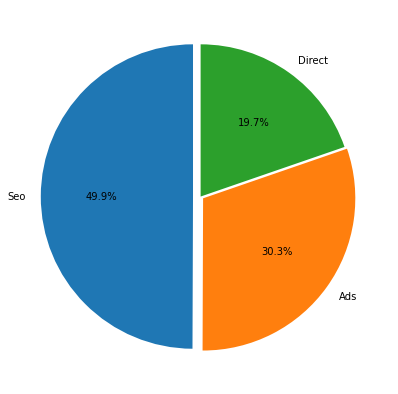

In [10]:

# Group by source on only converted dataset
mask_converted = df["converted"] == 1
converted_source_df = pd.DataFrame(df[mask_converted].groupby(["source"]).size()).reset_index()

# rename columns
converted_source_df = converted_source_df.rename(columns={0: "Users converted by source"})  

# change values to percentage
converted_source_df["Users converted by source"] = (converted_source_df["Users converted by source"] / converted_source_df["Users converted by source"].sum()) * 100

# sort values in descending
converted_source_df = converted_source_df.sort_values(["Users converted by source"], ascending=False)

# pie chart
converted_by_source = converted_source_df["Users converted by source"].values
names = list(converted_source_df["source"].unique())
explode = (0.05,0.02,0)

fig, ax = plt.subplots(figsize=(7,7))
_ = ax.pie(converted_by_source, labels=names, 
       autopct="%1.1f%%", 
       explode=explode, 
       shadow=False,
       startangle=90) 


Preprocessing Pipeline

In [11]:
# missing values
print("Percentage of missing values in dataset: ")
display(100*df.isnull().sum()/df.shape[0])
print("No missing values in dataset")

Percentage of missing values in dataset: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

No missing values in dataset


In [12]:
# columns
display(df.columns)

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [13]:
# choose features & target
features_vars = ["age", "new_user", "total_pages_visited"]
target_var = "converted"

In [14]:
# separate target variable from others
Y_df = df.loc[:,target_var]
X_df = df.loc[:,features_vars]

print("Separating labels from features...")
print("Target")
print(Y_df.head())

print("\nFeatures")
print(X_df.head())
print()

Separating labels from features...
Target
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

Features
   age  new_user  total_pages_visited
0   22         1                    2
1   21         1                    3
2   20         0                   14
3   23         1                    3
4   28         1                    3



In [15]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X = X_df.values
Y = Y_df.tolist()
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[22  1  2]
 [21  1  3]
 [20  0 14]
 [23  1  3]
 [28  1  3]]

[0, 0, 1, 0, 0]


In [16]:
# Separate target variable Y from features X
print("Separating labels from features...")
features_list = ["age", "new_user", "total_pages_visited"]
target_variable = "converted"

X = df.loc[:,features_list]
Y = df.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   age  new_user  total_pages_visited
0   22         1                    2
1   21         1                    3
2   20         0                   14
3   23         1                    3
4   28         1                    3


In [17]:
# Automatically detect positions of numeric/categorical features
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['age', 'new_user', 'total_pages_visited']  at positions  [0, 1, 2]
Found categorical features  []  at positions  []


In [18]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [19]:
# numeric transformation 
numeric_transformer = Pipeline(
    steps=[
        ("num_imputer", SimpleImputer(strategy="mean")),
        ("num_scaler", StandardScaler())
    ]
)

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])

# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

...Done
[[-1.3990984   0.67651656 -1.15935344]
 [ 0.29299544  0.67651656  0.03743241]
 [ 2.46854467  0.67651656 -0.86015697]
 [-1.64082609 -1.47816042 -1.15935344]
 [-0.31132378  0.67651656  0.03743241]]
Encoding labels...
137434    0
112323    0
143261    0
162328    0
158039    0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]


Model 1 : LogisticRegression


In [20]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [21]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [22]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print(X_test.head())
X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Encoding categorical features and standardizing numerical features...
        age  new_user  total_pages_visited
138303   34         1                    1
133130   32         0                    5
245758   44         1                    1
185267   35         1                    1
177637   29         1                    3
...Done
[[ 0.41385929  0.67651656 -1.15935344]
 [ 0.1721316  -1.47816042  0.03743241]
 [ 1.62249775  0.67651656 -1.15935344]
 [ 0.53472314  0.67651656 -1.15935344]
 [-0.19045994  0.67651656 -0.56096051]]
Encoding labels...
138303    0
133130    0
245758    0
185267    0
177637    0
Name: converted, dtype: int64
...Done
[0 0 0 0 0]


In [23]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [24]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9853643966547192
accuracy on test set :  0.9846264670742849

f1-score on training set :  0.7457652983366396
f1-score on test set :  0.7341233667578245



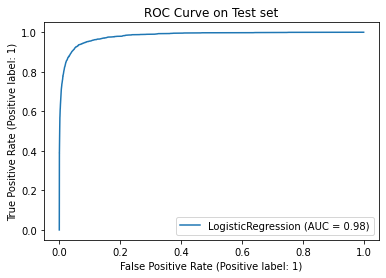

In [26]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

Model 2 : Decision Tree


In [ ]:
# Perform grid search
print("Grid search...")
classifier = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9854654227282311
accuracy on test set :  0.9843629207955583

f1-score on training set :  0.745793961742337
f1-score on test set :  0.7284929835265406



RANDOM FOREST


In [ ]:
# Perform grid search
print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 40}
Best validation accuracy :  0.9853336495888678


In [ ]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



In [ ]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.9854302832244008
accuracy on test set :  0.9844331998032188

f1-score on training set :  0.7453358925143954
f1-score on test set :  0.729713239780354



## Competition (best model)
Use our best model, train on all training competition dataset and test on competitor (TA) tetst data.

In [ ]:
# Concatenate our train and
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

display(X.shape)

(284580, 3)

In [ ]:
# train model
classifier.fit(X,Y)

RandomForestClassifier()

In [ ]:
# Q1 test dataset
data_without_labels = pd.read_csv('/content/JEDHA_Project/conversion_data_test.csv')
print('Test dataset :', data_without_labels.shape)

Kaggle test dataset : (31620, 5)


In [ ]:
# Feature engineering
# fetch features
features_vars = ["age", "new_user", "total_pages_visited"]
X_without_labels_df = data_without_labels.loc[:, features_vars]

# convert to array (DataFrame)
X_without_labels = X_without_labels_df.values

# preprocessing
X_without_labels = preprocessor.transform(X_without_labels) 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



In [ ]:
# prediction
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('/content/JEDHA_Project/Test_Prediction.csv', index=False)